In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

Read the processed data sets

In [ ]:
hlca_smoker = sc.read_h5ad("/ocean/projects/hmcmutc/qsong/projects/lung_aging/data/step1_HLCA_smoker_processed.h5ad")
hlca_nonsmoker = sc.read_h5ad("/ocean/projects/hmcmutc/qsong/projects/lung_aging/data/step1_HLCA_nonsmoker_processed.h5ad")
nuc_smoker = sc.read_h5ad("/ocean/projects/hmcmutc/qsong/projects/lung_aging/data/step1_nuc_smoker_processed.h5ad")
nuc_nonsmoker = sc.read_h5ad("/ocean/projects/hmcmutc/qsong/projects/lung_aging/data/step1_nuc_nonsmoker_processed.h5ad")

## Data Integration by mnnpy

In [ ]:
from functools import reduce
import mnnpy

Get highly variable genes

In [ ]:
sc.pp.highly_variable_genes(hlca_smoker,inplace = True)
sc.pp.highly_variable_genes(nuc_smoker,inplace = True)
sc.pp.highly_variable_genes(hlca_nonsmoker,inplace = True)
sc.pp.highly_variable_genes(nuc_nonsmoker,inplace = True)

### Integration 1: nuc-seq(smoker) -> HLCA(smoker)

In [9]:
hvg = np.intersect1d(nuc_smoker.var.index[nuc_smoker.var['highly_variable']],
               hlca_smoker.var.index[hlca_smoker.var['highly_variable']]
              )

comm_genes = np.intersect1d(nuc_smoker.var_names, hlca_smoker.var_names)
nuc_smoker = nuc_smoker[:,comm_genes].copy()
hlca_smoker = hlca_smoker[:,comm_genes].copy()
nuc_smoker.obs = nuc_smoker.obs.loc[:,['dataset']]
hlca_smoker.obs = hlca_smoker.obs.loc[:,['dataset']]

corrected = mnnpy.mnn_correct(hlca_smoker, nuc_smoker,
                              var_subset = hvg,
                              batch_categories = ["HLCA","nuc-seq"],
                              n_jobs = 60
                             )

/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


How well is the integration?

/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
... storing 'dataset' as categorical
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


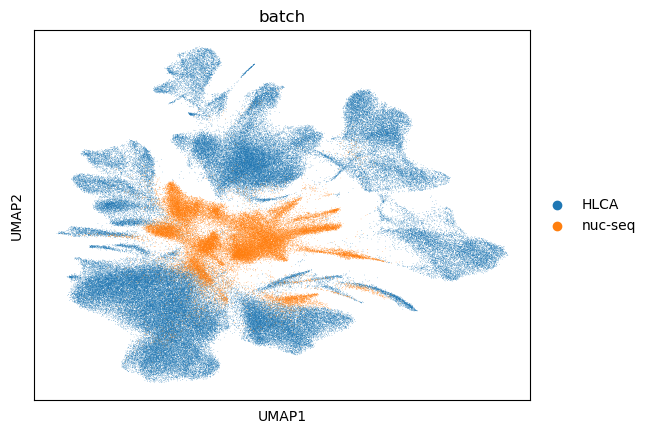

In [10]:
bdata = corrected[0][:, hvg]
sc.pp.scale(bdata)
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)
sc.pl.umap(bdata, color='batch')

Save the corrected data

In [11]:
if not os.path.isdir("results/correction_mnnpy"):
    os.mkdir("results/correction_mnnpy")
corrected[0].write_h5ad("results/correction_mnnpy/corrected_nuc_smoker.h5ad")

... storing 'dataset' as categorical


### Integration 2: nuc-seq(nonsmoker) -> HLCA(nonsmoker)

In [12]:
hvg = np.intersect1d(nuc_nonsmoker.var.index[nuc_nonsmoker.var['highly_variable']],
               hlca_nonsmoker.var.index[hlca_nonsmoker.var['highly_variable']]
              )

comm_genes = np.intersect1d(nuc_nonsmoker.var_names, hlca_nonsmoker.var_names)
nuc_nonsmoker = nuc_nonsmoker[:,comm_genes]
hlca_nonsmoker = hlca_nonsmoker[:,comm_genes]
nuc_nonsmoker.obs = nuc_nonsmoker.obs.loc[:,['dataset']]
hlca_nonsmoker.obs = hlca_nonsmoker.obs.loc[:,['dataset']]

corrected_nonsmoker = mnnpy.mnn_correct(hlca_nonsmoker, nuc_nonsmoker,
                              var_subset = hvg,
                              batch_categories = ["HLCA","nuc-seq"],
                              n_jobs = 60
                             )

/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'dataset' as categorical
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


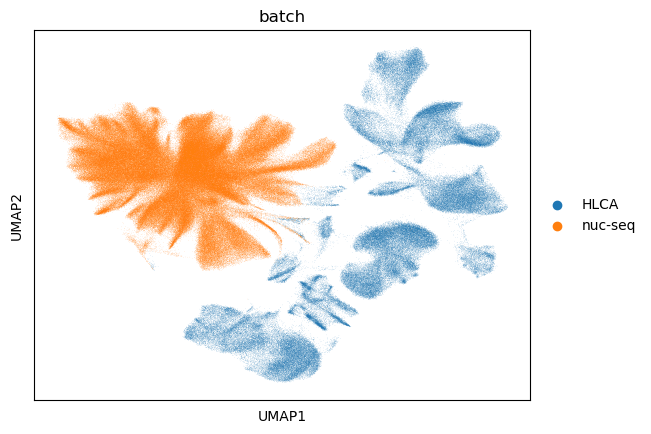

In [13]:
bdata = corrected_nonsmoker[0][:, hvg]
sc.pp.scale(bdata)
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)
sc.pl.umap(bdata, color='batch')

Save the corrected data

In [14]:
if not os.path.isdir("results/correction_mnnpy"):
    os.mkdir("results/correction_mnnpy")
corrected_nonsmoker[0].write_h5ad("results/correction_mnnpy/corrected_nuc_nonsmoker.h5ad")

... storing 'dataset' as categorical
